# I’m Something of a Painter Myself

The purpose of this project is to generate with realistic images which look like Monat's pictures.
Kaggle Competition: https://www.kaggle.com/competitions/gan-getting-started/overview

The method `GANs` can achieve this.
![51391generator_and_discriminator.png](attachment:./916e42d0-39db-4399-bec2-6baca006c250.png)
Image Source: https://www.analyticsvidhya.com/blog/2021/04/lets-talk-about-gans/

## Summary

I used GANs. But it was difficult for me to implement the method even though I understand the concept.


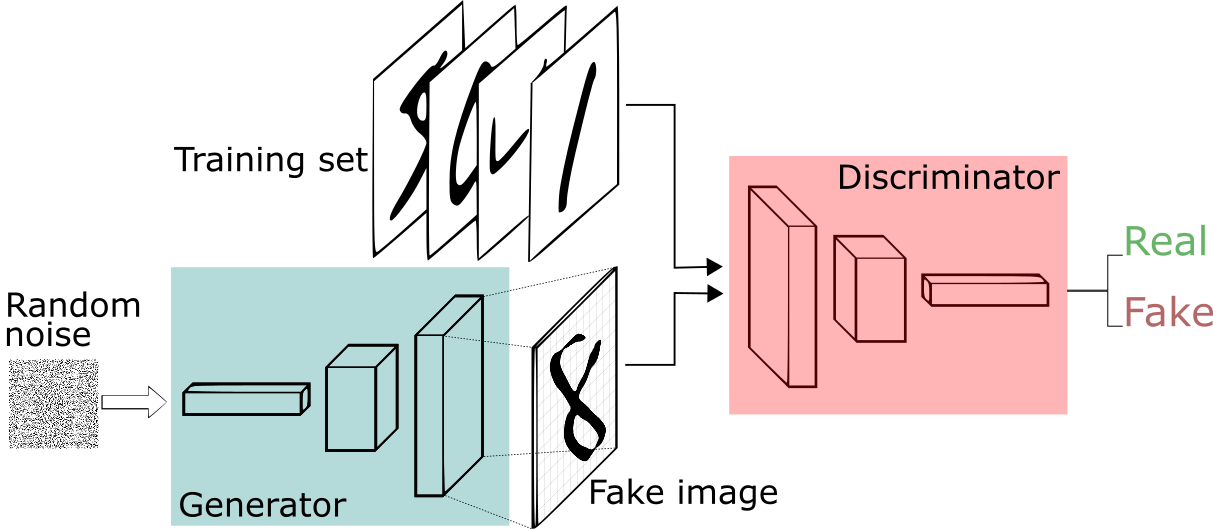

# Table of Contents
1. Importing Libraries and Dataset
2. Exploring Data
3. Training Models
4. Discussion

# 1. Importing Libraries and Dataset

## Importing Libraries

First, we will import the libraries to be used in this project.

In [1]:
import os
import re
import numpy as np
import shutil
import PIL
import matplotlib.pyplot as plt
import pandas as pd 
import cv2

import tensorflow as tf
import tensorflow.keras.layers as layers

from tensorflow import keras
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from numpy.random import randn

## Importing Dataset

Second, we will import tha dataset. The dataset has 300 Monet's pictures and 7038 real photos, all of which are RGB-colored, 2-dimensions and 256px-squared.

In [2]:
MONET_PATH = '../input/gan-getting-started/monet_tfrec/*.tfrec'
PHOTO_PATH = '../input/gan-getting-started/photo_tfrec/*.tfrec'

monet_files = tf.io.gfile.glob(MONET_PATH)
photo_files = tf.io.gfile.glob(PHOTO_PATH)

def count_data_items(files):
    n = [int(re.compile(r"-([0-9]*)\.").search(file).group(1)) for file in files]
    return np.sum(n)

n_monets = count_data_items(monet_files)
n_photos = count_data_items(photo_files)

print('The Number of Monet\'s Pictures: ', n_monets)
print('The Number of Read Photos: ', n_photos)

The Number of Monet's Pictures:  300
The Number of Read Photos:  7038


Loading all of the pictures.

In [3]:
CHANNELS = 3 # RGB color images
DIMENSIONS = 2 # 2D image
IMAGE_SIZE = [256, 256] # 256px x 256px

def read_tfrecord(file):
    file = tf.io.parse_single_example(file, {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    })
    img = tf.image.decode_image(file['image'], channels=CHANNELS)
    img = (tf.cast(img, tf.float32)/127.5)-1
    return  tf.reshape(img, [*IMAGE_SIZE, CHANNELS])

def load_dataset(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(read_tfrecord)
    return dataset

monet_data = load_dataset(monet_files).batch(1)
photo_data = load_dataset(photo_files).batch(1)

# 2. Exploring Data

## Displaying Pictures

First, we will show all of the pictures.

In [4]:
def show_pictures(pic_arr, row, col):
    it = iter(pic_arr)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        sample = next(it)
        plt.subplot(row, col, j+1)
        plt.axis('off')
        plt.imshow(sample[0] * 0.5 + 0.5)
    plt.show()

### Showing the Monet's Pictures

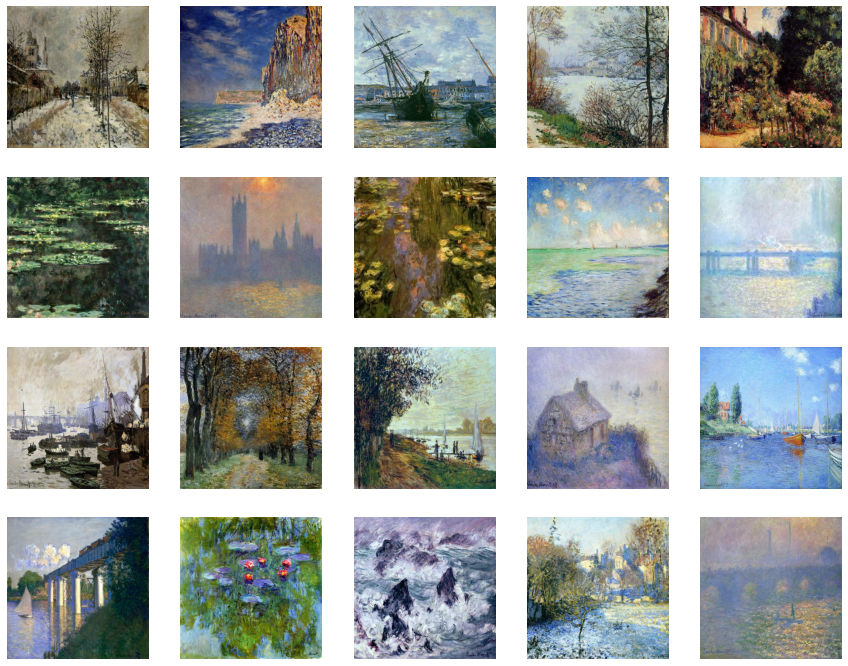

In [5]:
show_pictures(monet_data, 4, 5)

### Showing the Real Photos

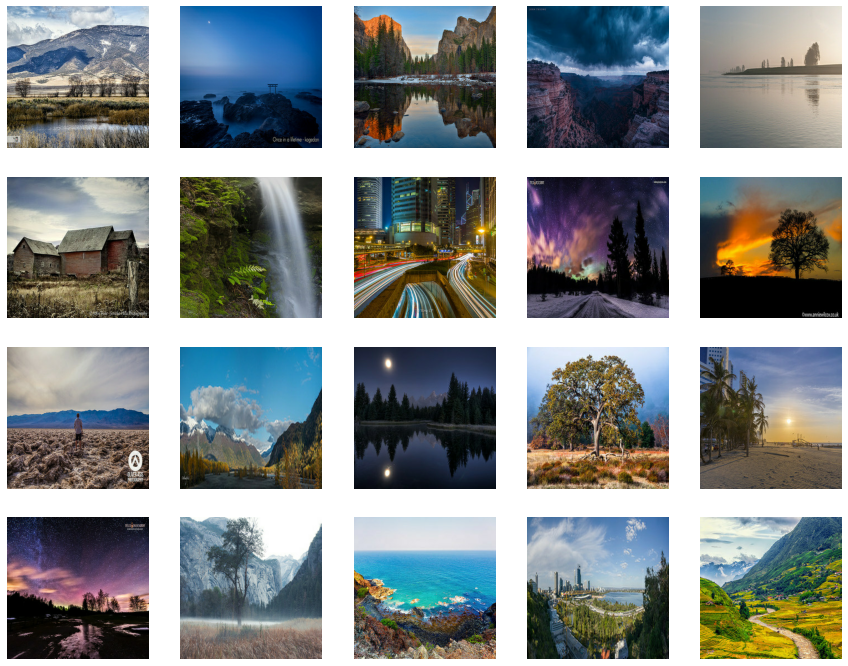

In [6]:
show_pictures(photo_data, 4, 5)

# 3. Training Models

## Creating A Generator

First, we will create a generator.

In [7]:
def create_generator():
    inputs = layers.Input(shape=[256,256,3,])
    
    init = RandomNormal(mean=0.0, stddev=0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)    
    
    conv1 = layers.Conv2D(32, 4, strides=2, padding='same', kernel_initializer=init)(inputs)
    conv1 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv1)
    conv1 = layers.LeakyReLU()(conv1)
    
    conv2 = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init)(conv1)
    conv2 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv2)
    conv2 = layers.LeakyReLU()(conv2)
    
    conv3 = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=init)(conv2)
    conv3 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv3)
    conv3 = layers.LeakyReLU()(conv3)
    
    conv4 = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=init)(conv3)
    conv4 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv4)
    conv4 = layers.LeakyReLU()(conv4)
    
    conv5 = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=init)(conv4)
    conv5 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv5)
    conv5 = layers.LeakyReLU()(conv5)
     
    up1 = layers.Conv2DTranspose(256, 4, strides=(2,2), padding='same', kernel_initializer=init)(conv5)
    up1 = layers.BatchNormalization(gamma_initializer=gamma_init)(up1)
    up1 = layers.LeakyReLU()(up1)
    merge1 = layers.concatenate([up1, conv4], axis=3) 
    
    up2 = layers.Conv2DTranspose(128, 4, strides=(2,2), padding='same', kernel_initializer=init)(merge1)
    up2 = layers.BatchNormalization(gamma_initializer=gamma_init)(up2)
    up2 = layers.LeakyReLU()(up2)
    merge2 = layers.concatenate([up2, conv3], axis=3) 

    up3 = layers.Conv2DTranspose(64, 4, strides=(2,2), padding='same', kernel_initializer=init)(merge2)
    up3 = layers.BatchNormalization(gamma_initializer=gamma_init)(up3)
    up3 = layers.Dropout(0.5)(up3)
    up3 = layers.LeakyReLU()(up3)
    merge3 = layers.concatenate([up3, conv2], axis=3) 
    
    up4 = layers.Conv2DTranspose(32, 4, strides=(2,2), padding='same', kernel_initializer=init)(merge3)
    up4 = layers.BatchNormalization(gamma_initializer=gamma_init)(up4)
    up4 = layers.Dropout(0.5)(up4)
    up4 = layers.LeakyReLU()(up4)
    merge4 = layers.concatenate([up4, conv1], axis=3) 
    
    x = layers.Conv2DTranspose(3, 4, strides=(2,2), activation='tanh', padding='same')(merge4)

    return keras.Model(inputs=inputs, outputs=x)

Showing the summary of generator.

In [8]:
generator = create_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1568        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Creating A Discriminator

Second, we will create a discriminator.

In [9]:
def create_discriminator():
    discriminator_input = layers.Input(shape=[256, 256, 3], name='input_image')
    init= RandomNormal(mean=0.0, stddev=0.02)
    
    x = layers.Conv2D(64, 4, kernel_initializer=init)(discriminator_input)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 4, strides=2, kernel_initializer=init)(x)
    x = layers.LeakyReLU(0.2)(x)
  
    x = layers.Conv2D(128, 4, strides=2, kernel_initializer=init)(x)
    x = layers.LeakyReLU()(x)
  
    x = layers.Flatten()(x)
  
    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(discriminator_input, x)

Showing the summary of discriminator.

In [10]:
discriminator = create_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 253, 253, 64)      3136      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 253, 253, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 128)     131200    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 125, 125, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 61, 61, 128)       0   

## Creating A GANs Model

With the generator and discriminator, a GANs model is created here.

In [11]:
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator= discriminator

    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, disc_loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
       
    def train_step(self, data):
        real_monet, real_photo = data
        
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generator(real_photo, training=True)

            real_output = self.discriminator(real_monet, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            generator_loss = self.gen_loss_fn(fake_output)
            discriminator_loss =self.disc_loss_fn(real_output,fake_output) 
       
        generator_gradients = tape.gradient(generator_loss,self.generator.trainable_variables)
        discriminator_gradients = tape.gradient(discriminator_loss,self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(discriminator_gradients,self.discriminator.trainable_variables))

        return {
            "generator_loss": generator_loss,
            "discriminator_loss": discriminator_loss
        }

### Defining Optimizers

In [12]:
gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)

### Defining Loss Functions

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
     return cross_entropy(tf.ones_like(fake_output), fake_output)

def descriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss+fake_loss

## Training the Model

In [14]:
model = GAN(generator, discriminator)
model.compile(
    gen_optimizer,
    disc_optimizer,
    generator_loss,
    descriminator_loss
)

model.fit(tf.data.Dataset.zip((monet_data, photo_data)),epochs=100)

Epoch 1/100
300/300 [==============================] - 16s 23ms/step - generator_loss: 5.0182 - discriminator_loss: 0.3953
Epoch 2/100
300/300 [==============================] - 7s 22ms/step - generator_loss: 2.4862 - discriminator_loss: 0.7172
Epoch 3/100
300/300 [==============================] - 7s 22ms/step - generator_loss: 2.1139 - discriminator_loss: 0.6351
Epoch 4/100
300/300 [==============================] - 7s 23ms/step - generator_loss: 2.0258 - discriminator_loss: 0.6681
Epoch 5/100
300/300 [==============================] - 7s 22ms/step - generator_loss: 2.1160 - discriminator_loss: 0.6451
Epoch 6/100
300/300 [==============================] - 7s 23ms/step - generator_loss: 2.4678 - discriminator_loss: 0.5823
Epoch 7/100
300/300 [==============================] - 7s 22ms/step - generator_loss: 2.1851 - discriminator_loss: 0.6736
Epoch 8/100
300/300 [==============================] - 7s 22ms/step - generator_loss: 2.3600 - discriminator_loss: 0.6751
Epoch 9/100
300/300 [==

## Generating Samples

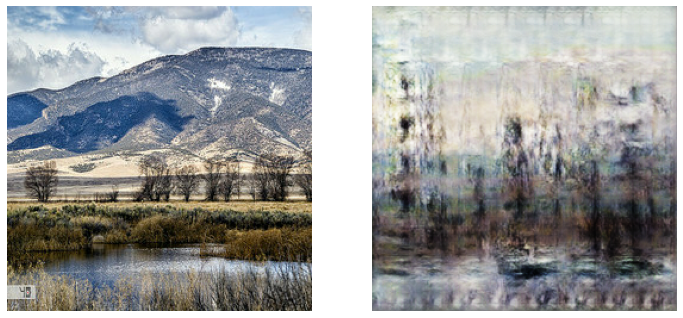

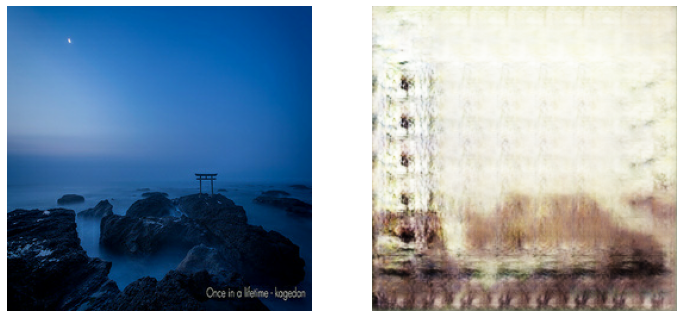

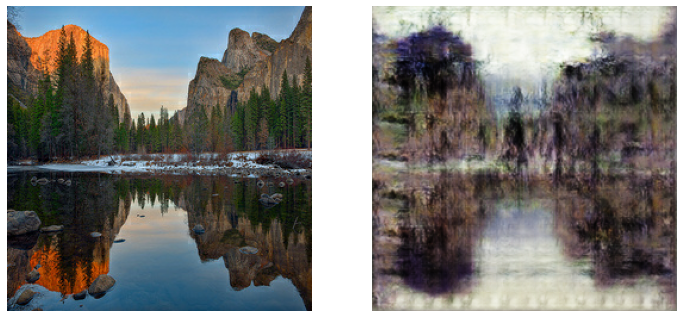

In [15]:
def show_comparison(photo, gen):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    # real
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(photo * 0.5 + 0.5)
    # generated
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(gen * 0.5 + 0.5)
    plt.show()

it = iter(photo_data)
for i in range(3):
    photo = next(it)
    pred = generator(photo, training=False)
    show_comparison(photo[0], pred[0])

# 4. Discussion



I don't think the result is not good enought for practical use. It was difficult for me to implement the method even though I understand the concept.

The problems are:
- I don't know how to adjust the GANs models
- I don't know how to make a model more complex

I'd like to try again after I learn the cutting edge of GANs.

### Submission

In [16]:
! mkdir ../images
i = 1

for img in photo_data:
    prediction = generator(img, training=False).numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    
    im = PIL.Image.fromarray(prediction[0])
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'